# Clustering de documents

## Imports

In [1]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [2]:
import nltk

nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [3]:
data_path = "../data/txt/"

## Choisir une décennie

In [4]:
DECADE = '1950'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [5]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [31]:
# Exemple de fichiers
files[:50]

['KB_JB838_1950-01-06_01-00002.txt',
 'KB_JB838_1950-01-07_01-00013.txt',
 'KB_JB838_1950-01-08_01-00011.txt',
 'KB_JB838_1950-01-10_01-00006.txt',
 'KB_JB838_1950-01-15_01-00010.txt',
 'KB_JB838_1950-01-22_01-00014.txt',
 'KB_JB838_1950-02-13_01-00005.txt',
 'KB_JB838_1950-02-13_01-00008.txt',
 'KB_JB838_1950-02-15_01-00011.txt',
 'KB_JB838_1950-02-15_01-00014.txt',
 'KB_JB838_1950-02-16_01-00014.txt',
 'KB_JB838_1950-02-17_01-00009.txt',
 'KB_JB838_1950-02-18_01-00009.txt',
 'KB_JB838_1950-02-18_01-00014.txt',
 'KB_JB838_1950-02-25_01-00006.txt',
 'KB_JB838_1950-02-25_01-00013.txt',
 'KB_JB838_1950-02-28_01-00012.txt',
 'KB_JB838_1950-03-01_01-00005.txt',
 'KB_JB838_1950-03-03_01-00013.txt',
 'KB_JB838_1950-03-05_01-00020.txt',
 'KB_JB838_1950-03-11_01-00005.txt',
 'KB_JB838_1950-03-15_01-00012.txt',
 'KB_JB838_1950-03-19_01-00001.txt',
 'KB_JB838_1950-03-25_01-00009.txt',
 'KB_JB838_1950-03-27_01-00002.txt',
 'KB_JB838_1950-03-29_01-00002.txt',
 'KB_JB838_1950-03-29_01-00008.txt',
 

In [7]:
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [8]:
# Exemple de textes
texts[0][:400]

'/ LE SOIR Une importante manifestation franco-belge Le Comité franco-belge du Commerce, de l’Industrie et de l’Agriculture qui. au cours de l’année écoulée et dans les circonstances les plus difficiles a rendu aux relations économiques entre les deux pays des services considérables, donnera le 12 janvier, à 19 h. 30, un dîner à l’occasion de l’anniversaire de son installation. Ce comité, qui fonct'

## Vectoriser les documents à l'aide de TF-IDF

In [9]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [10]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [11]:
tfidf_vectors = vectorizer.fit_transform(texts)

c:\Users\User\Documents\Ma STIC\Ma STIC II\Traitement Automatique de Corpus\2023-2024\TDs\tac\tac_venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# Détail de la matrice
tfidf_vectors

<1000x3506 sparse matrix of type '<class 'numpy.float64'>'
	with 703414 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [13]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

parti           0.276898
loyer           0.152154
janvier         0.147984
populaire       0.147399
propriétaire    0.143645
                  ...   
enquête         0.000000
ent             0.000000
entend          0.000000
enthousiasme    0.000000
italiens        0.000000
Length: 3506, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [14]:
cosine([1, 2, 3], [1, 2, 3])

0

In [15]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [16]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

### Tests sur nos documents

In [17]:
tfidf_array = tfidf_vectors.toarray()

In [18]:
# Vecteur du document 0
tfidf_array[0]

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.03783191])

In [19]:
# Vecteur du document 1
tfidf_array[1]

array([0.       , 0.0067046, 0.       , ..., 0.       , 0.       ,
       0.       ])

In [20]:
cosine(tfidf_array[0], tfidf_array[1])

0.9314315949045398

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [21]:
N_CLUSTERS = 5

### Instancier le modèle K-Means et ses arguments

In [22]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [23]:
clusters = km_model.fit_predict(tfidf_vectors)

c:\Users\User\Documents\Ma STIC\Ma STIC II\Traitement Automatique de Corpus\2023-2024\TDs\tac\tac_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [25]:
pprint(dict(clustering))

{0: ['KB_JB838_1950-01-10_01-00006.txt',
     'KB_JB838_1950-01-15_01-00010.txt',
     'KB_JB838_1950-02-13_01-00005.txt',
     'KB_JB838_1950-02-13_01-00008.txt',
     'KB_JB838_1950-02-15_01-00014.txt',
     'KB_JB838_1950-02-17_01-00009.txt',
     'KB_JB838_1950-02-18_01-00009.txt',
     'KB_JB838_1950-02-25_01-00006.txt',
     'KB_JB838_1950-03-25_01-00009.txt',
     'KB_JB838_1950-04-26_01-00007.txt',
     'KB_JB838_1950-05-03_01-00006.txt',
     'KB_JB838_1950-06-04_01-00011.txt',
     'KB_JB838_1950-06-10_01-00010.txt',
     'KB_JB838_1950-06-17_01-00006.txt',
     'KB_JB838_1950-07-24_01-00006.txt',
     'KB_JB838_1950-07-27_01-00007.txt',
     'KB_JB838_1950-08-28_01-00005.txt',
     'KB_JB838_1950-09-04_01-00005.txt',
     'KB_JB838_1950-09-04_01-00006.txt',
     'KB_JB838_1950-09-17_01-00011.txt',
     'KB_JB838_1950-10-09_01-00005.txt',
     'KB_JB838_1950-10-16_01-00004.txt',
     'KB_JB838_1950-10-17_01-00006.txt',
     'KB_JB838_1950-11-06_01-00006.txt',
     'KB_JB838_1

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [26]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [27]:
reduced_vectors[:10]

array([[-0.32577068,  0.11394047],
       [ 0.11347135, -0.30167107],
       [ 0.44366539, -0.25250738],
       [-0.23888528, -0.0376523 ],
       [-0.05185305, -0.10498841],
       [ 0.61288627,  0.50398808],
       [-0.20409262, -0.03497794],
       [-0.19467468, -0.03777884],
       [ 0.62386851,  0.45618284],
       [ 0.15641292, -0.01409975]])

### Générer le plot

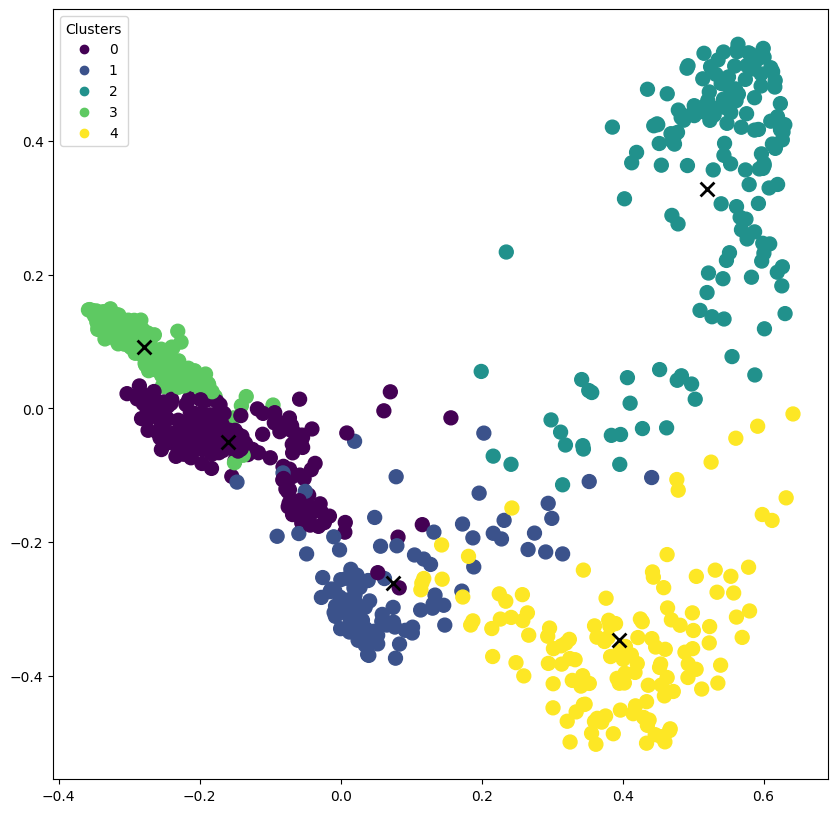

In [28]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")